# Do Popular Songs Endure?

## Dataset
- billboard hot 100 (from 1958 to 2017)
https://data.world/kcmillersean/billboard-hot-100-1958-2017

In [1]:
# Data processing
import pandas as pd
import numpy as np
import datetime as dt
from datetime import timedelta

# Visualization
import seaborn as sb
import matplotlib.pyplot as plt

# Machine learning
from sklearn.model_selection import train_test_split
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor

# Control Variables

In [2]:
feather = False

In [3]:
try:
    train_df = pd.read_feather('all/billboard_100')
except:
    train_df = pd.read_excel('all/Hot Stuff.xlsx')

try:
    song_df = pd.read_feather('all/lyrics')
except:
    song_df = pd.read_csv('all/lyrics.csv')

/anaconda3/envs/data-science/lib/python3.6/site-packages/pandas/io/feather_format.py:112: FutureWarning: `nthreads` argument is deprecated, pass `use_threads` instead
  return feather.read_dataframe(path, nthreads=nthreads)


In [4]:
list(train_df)

['url',
 'WeekID',
 'Week Position',
 'Song',
 'Performer',
 'SongID',
 'Instance',
 'Previous Week Position',
 'Peak Position',
 'Weeks on Chart']

In [5]:
train_df.rename(columns=lambda x: x.replace(' ', '_').lower(), inplace=True)

In [6]:
list(train_df)

['url',
 'weekid',
 'week_position',
 'song',
 'performer',
 'songid',
 'instance',
 'previous_week_position',
 'peak_position',
 'weeks_on_chart']

In [7]:
train_df['weekid'] = pd.to_datetime(train_df['weekid'], infer_datetime_format = True)

## Auxiliary functions

In [8]:
def insert_year(df):
    df.insert(df.shape[1], 'year', df.weekid.dt.year)

def insert_week(df):
    df.insert(df.shape[1], 'week', df.weekid.dt.week)

# def insert_rank(df):
#     df.insert(df.shape[1], 'rank', 100 - df['week_position'])
    

## Insert new features

In [9]:
insert_year(train_df)
insert_week(train_df)
# insert_rank(train_df)

## Basic Statistics

In [10]:
train_df.groupby(['performer', 'song']).mean().reset_index().describe()

,week_position,instance,previous_week_position,peak_position,weeks_on_chart,year,week
count,27278.000000,27278.000000,25423.000000,27278.000000,27278.000000,27278.000000,27278.000000
mean,61.768199,1.044308,58.727811,46.294468,11.325657,1983.949169,26.660472
std,23.574495,0.204984,23.797319,30.653372,7.975485,17.723926,11.716287
min,1.750000,1.000000,2.000000,0.000000,0.000000,1958.000000,1.000000
25%,41.727273,1.000000,38.181818,18.000000,5.000000,1968.000000,17.256944
50%,63.636364,1.000000,59.800000,45.000000,10.000000,1981.000000,26.500000
75%,82.250000,1.000000,79.000000,73.000000,16.000000,1999.000000,36.000000
max,100.000000,5.000000,100.000000,100.000000,87.000000,2017.000000,53.000000


In [11]:
train_df.shape

(309195, 12)

## Anomaly

In [12]:
song_by_performer = train_df.groupby(['song', 'performer'])
weird = []

for idx, (song, performer) in enumerate(song_by_performer):
    duration = max(performer['weekid']) - min(performer['weekid'])
    billboard_duration = timedelta(weeks = int(performer.iloc[0]['weeks_on_chart']) - 1)
    if duration != billboard_duration:
        weird.append(song)

In [13]:
print('DESCRIPTION:', len(weird))

DESCRIPTION: 1770


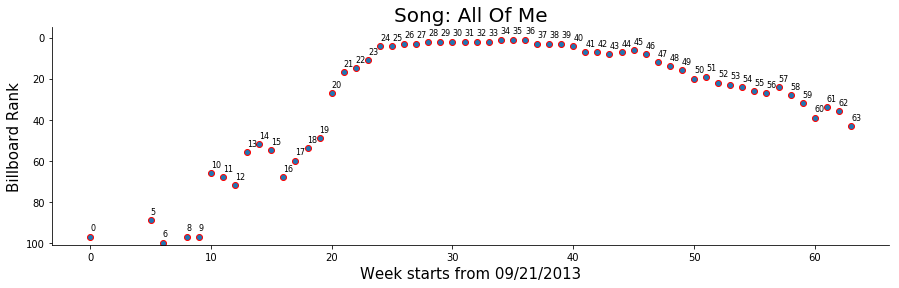

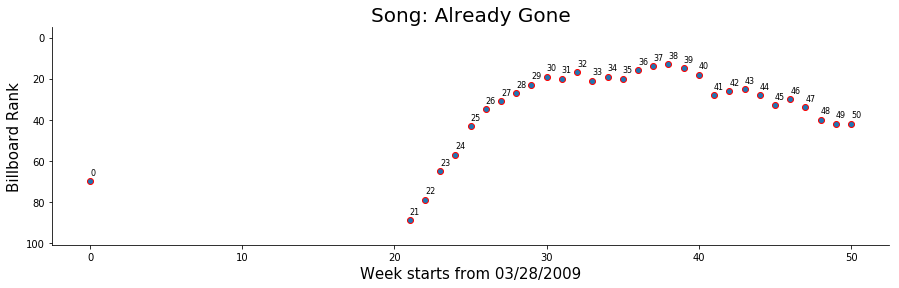

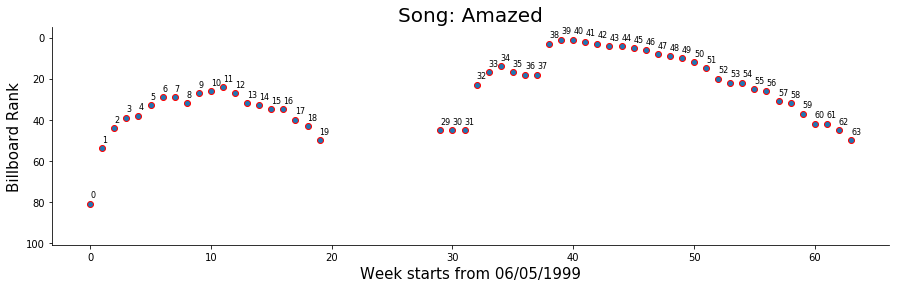

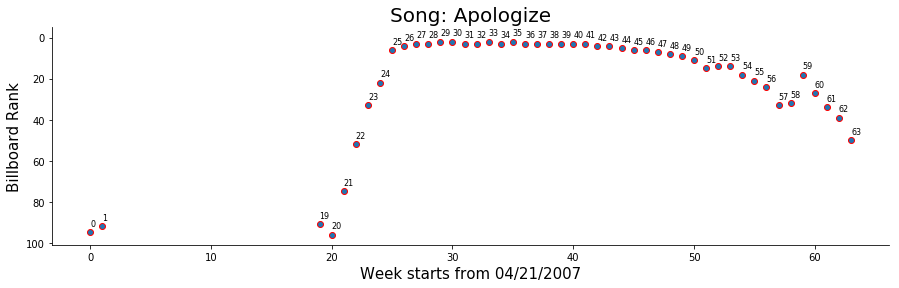

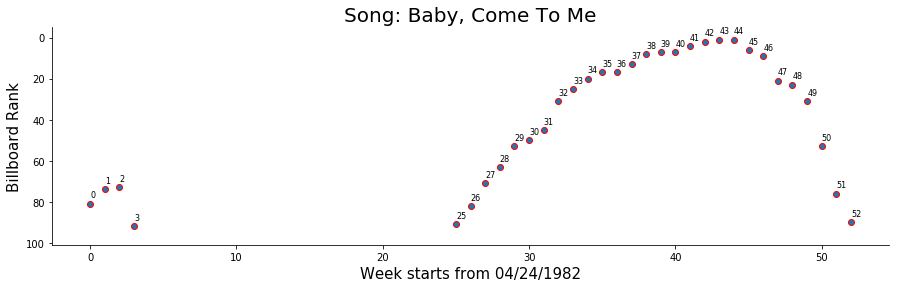

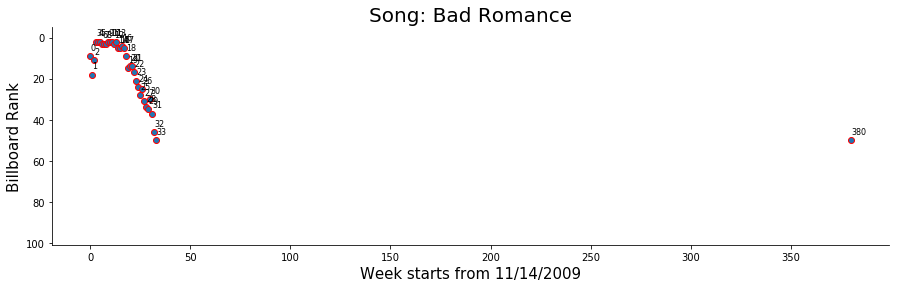

In [100]:
count = 0

for idx, info in enumerate(weird):
    x = train_df.loc[(train_df.song == info[0]) & (train_df.performer == info[1])]['weekid']
    y = train_df.loc[(train_df.song == info[0]) & (train_df.performer == info[1])]['week_position']
    if len(x) > 30:
        count += 1
        tmp = [((week-x.iloc[0])//7).days for week in x]
        
        fig = plt.figure(figsize=(15,4))
        ax = fig.add_subplot(111)
        ax.set_ylim(-5,101)
        plt.plot(tmp,y, linestyle='', marker='o', markeredgecolor='red')
        for i,j in zip(tmp,y):
            ax.annotate('{}'.format(i),xy=(i,j-3), fontsize=8)
        plt.gca().invert_yaxis()
#         ax = plt.gca()
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)
        ax.xaxis.set_ticks_position('bottom')
        ax.set_title('Song: ' + info[0], fontsize=20)
        plt.ylabel('Billboard Rank', fontsize=15)
        plt.xlabel('Week starts from {}'.format(x.iloc[0].strftime('%m/%d/%Y')), fontsize=15)
        if count > 5:
            break

In [ ]:
ranking_dist_df.head()

In [ ]:
ranking_dist_df.weeks_on_chart.describe()

---

# Data Cleaning

In [44]:
ranking_dist_df = train_df.groupby(['song', 'performer', 'weeks_on_chart'])['week_position'].apply(list).reset_index()

(array([    0.,   500.,  1000.,  1500.,  2000.,  2500.,  3000.]),
 <a list of 7 Text yticklabel objects>)

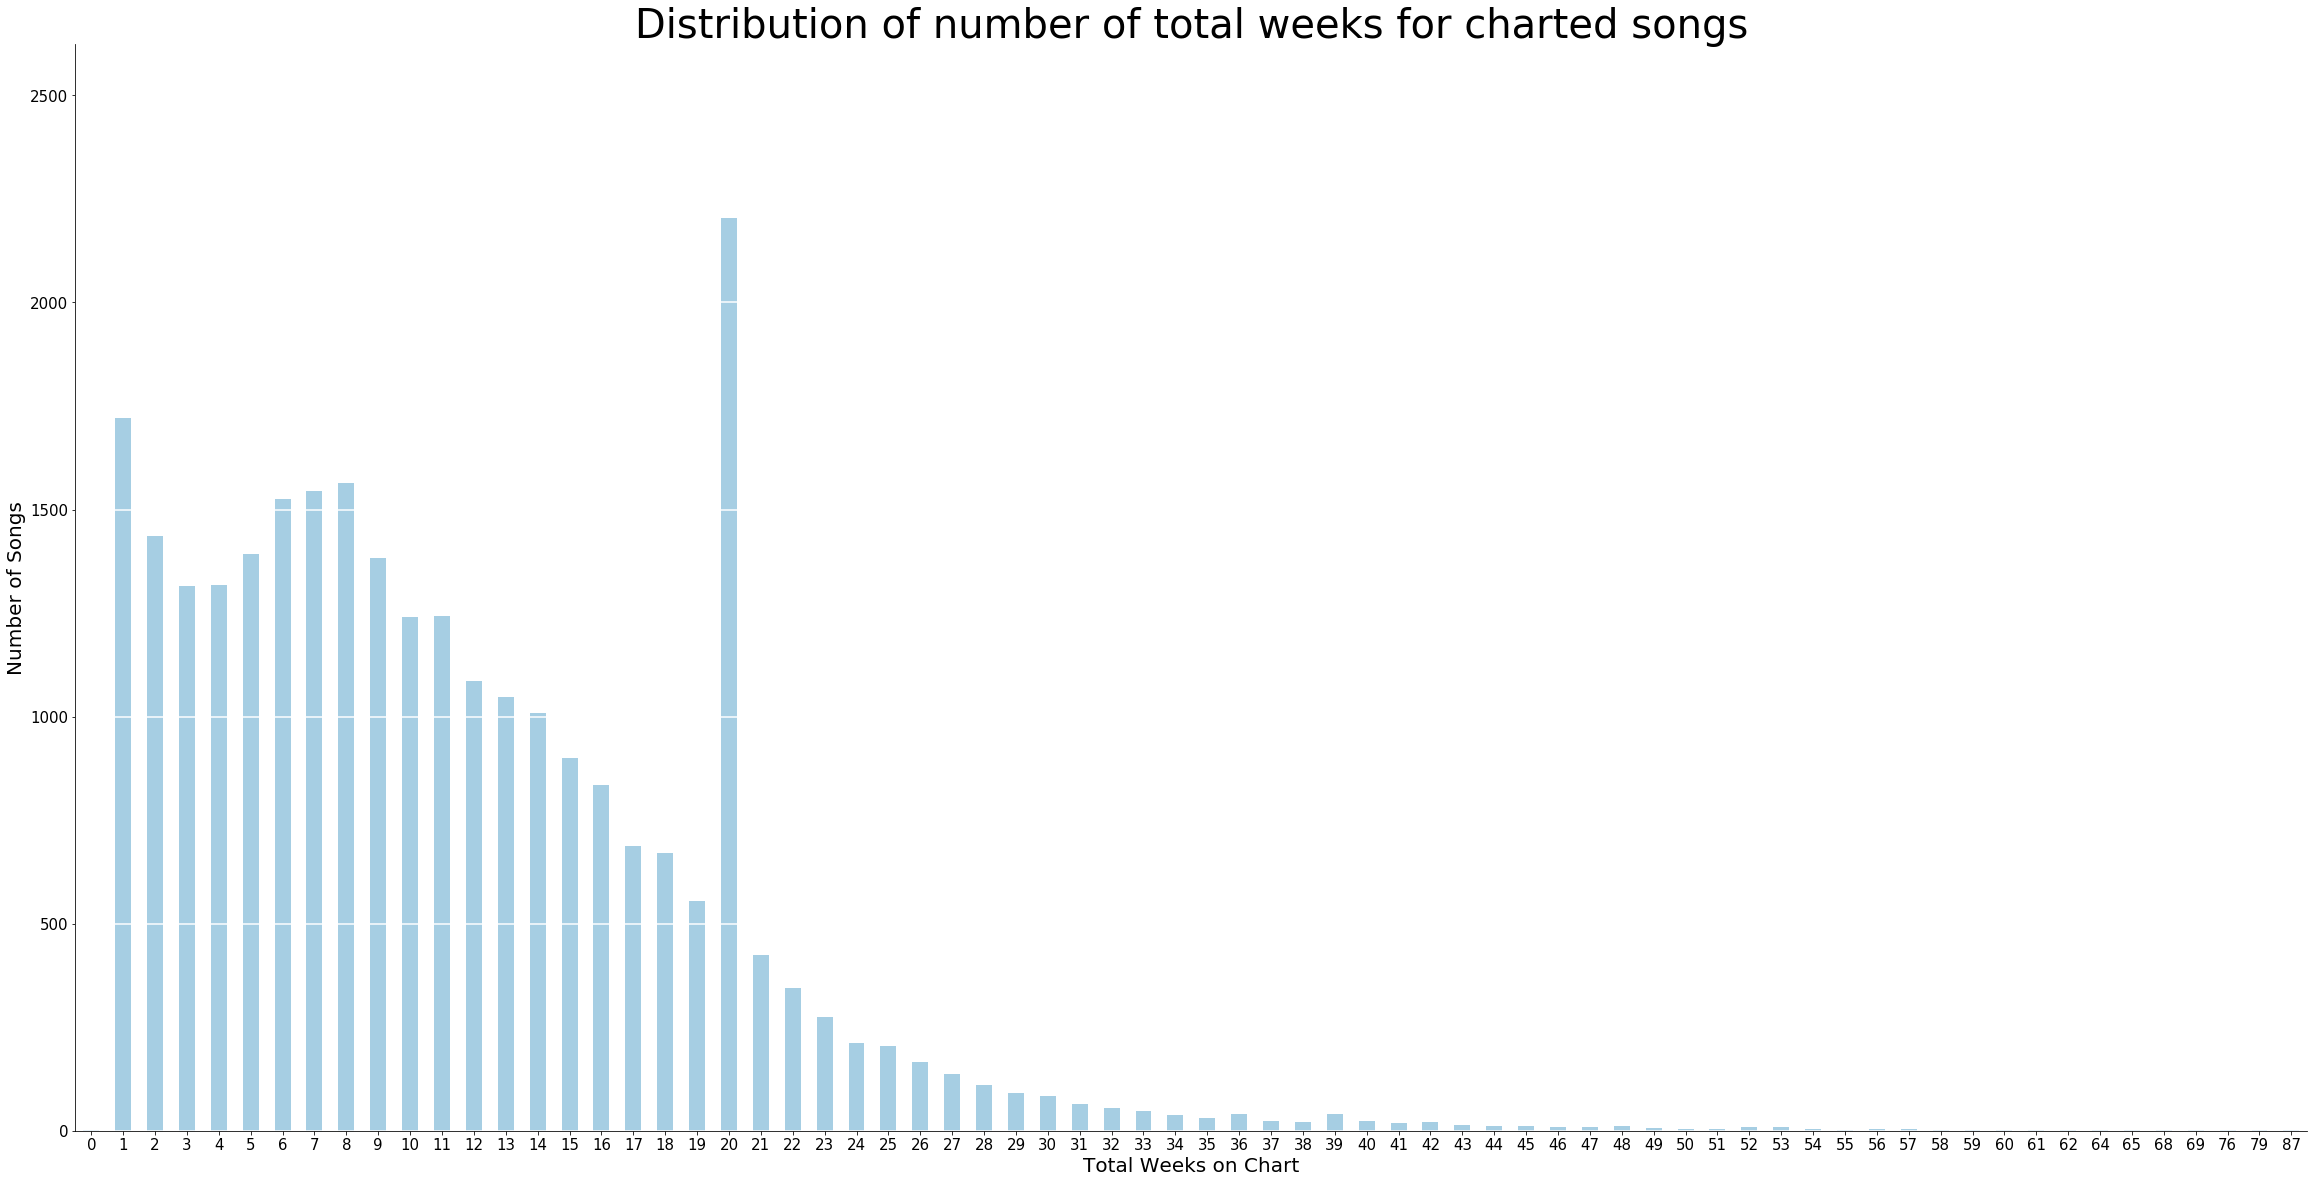

In [45]:
plt.figure(figsize=(40,20))
ranking_dist_df['weeks_on_chart'].value_counts().sort_index().plot(kind='bar', colormap='Paired')

ax = plt.gca()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.xaxis.set_ticks_position('bottom')
locs_y, labels_y = plt.yticks()

for loc in locs_y:
    ax.axhline(loc, color='white')

plt.title('Distribution of number of total weeks for charted songs', fontsize=40)
plt.ylabel('Number of Songs', fontsize=20)
plt.xlabel('Total Weeks on Chart', fontsize=20)
plt.xticks(rotation=0, fontsize=15)
plt.yticks(fontsize=15)

In [21]:
weird_songid = [song+artist for song, artist in weird]
clean_df = train_df.loc[~train_df.songid.isin(weird_songid)]

In [22]:
print(len(train_df.songid.value_counts()))
print(len(clean_df.songid.value_counts()))

27278
25508


In [64]:
ranking_dist_df = clean_df.groupby(['song', 'performer', 'songid', 'weeks_on_chart'])['week_position'].apply(list).reset_index()

(array([    0.,   500.,  1000.,  1500.,  2000.,  2500.]),
 <a list of 6 Text yticklabel objects>)

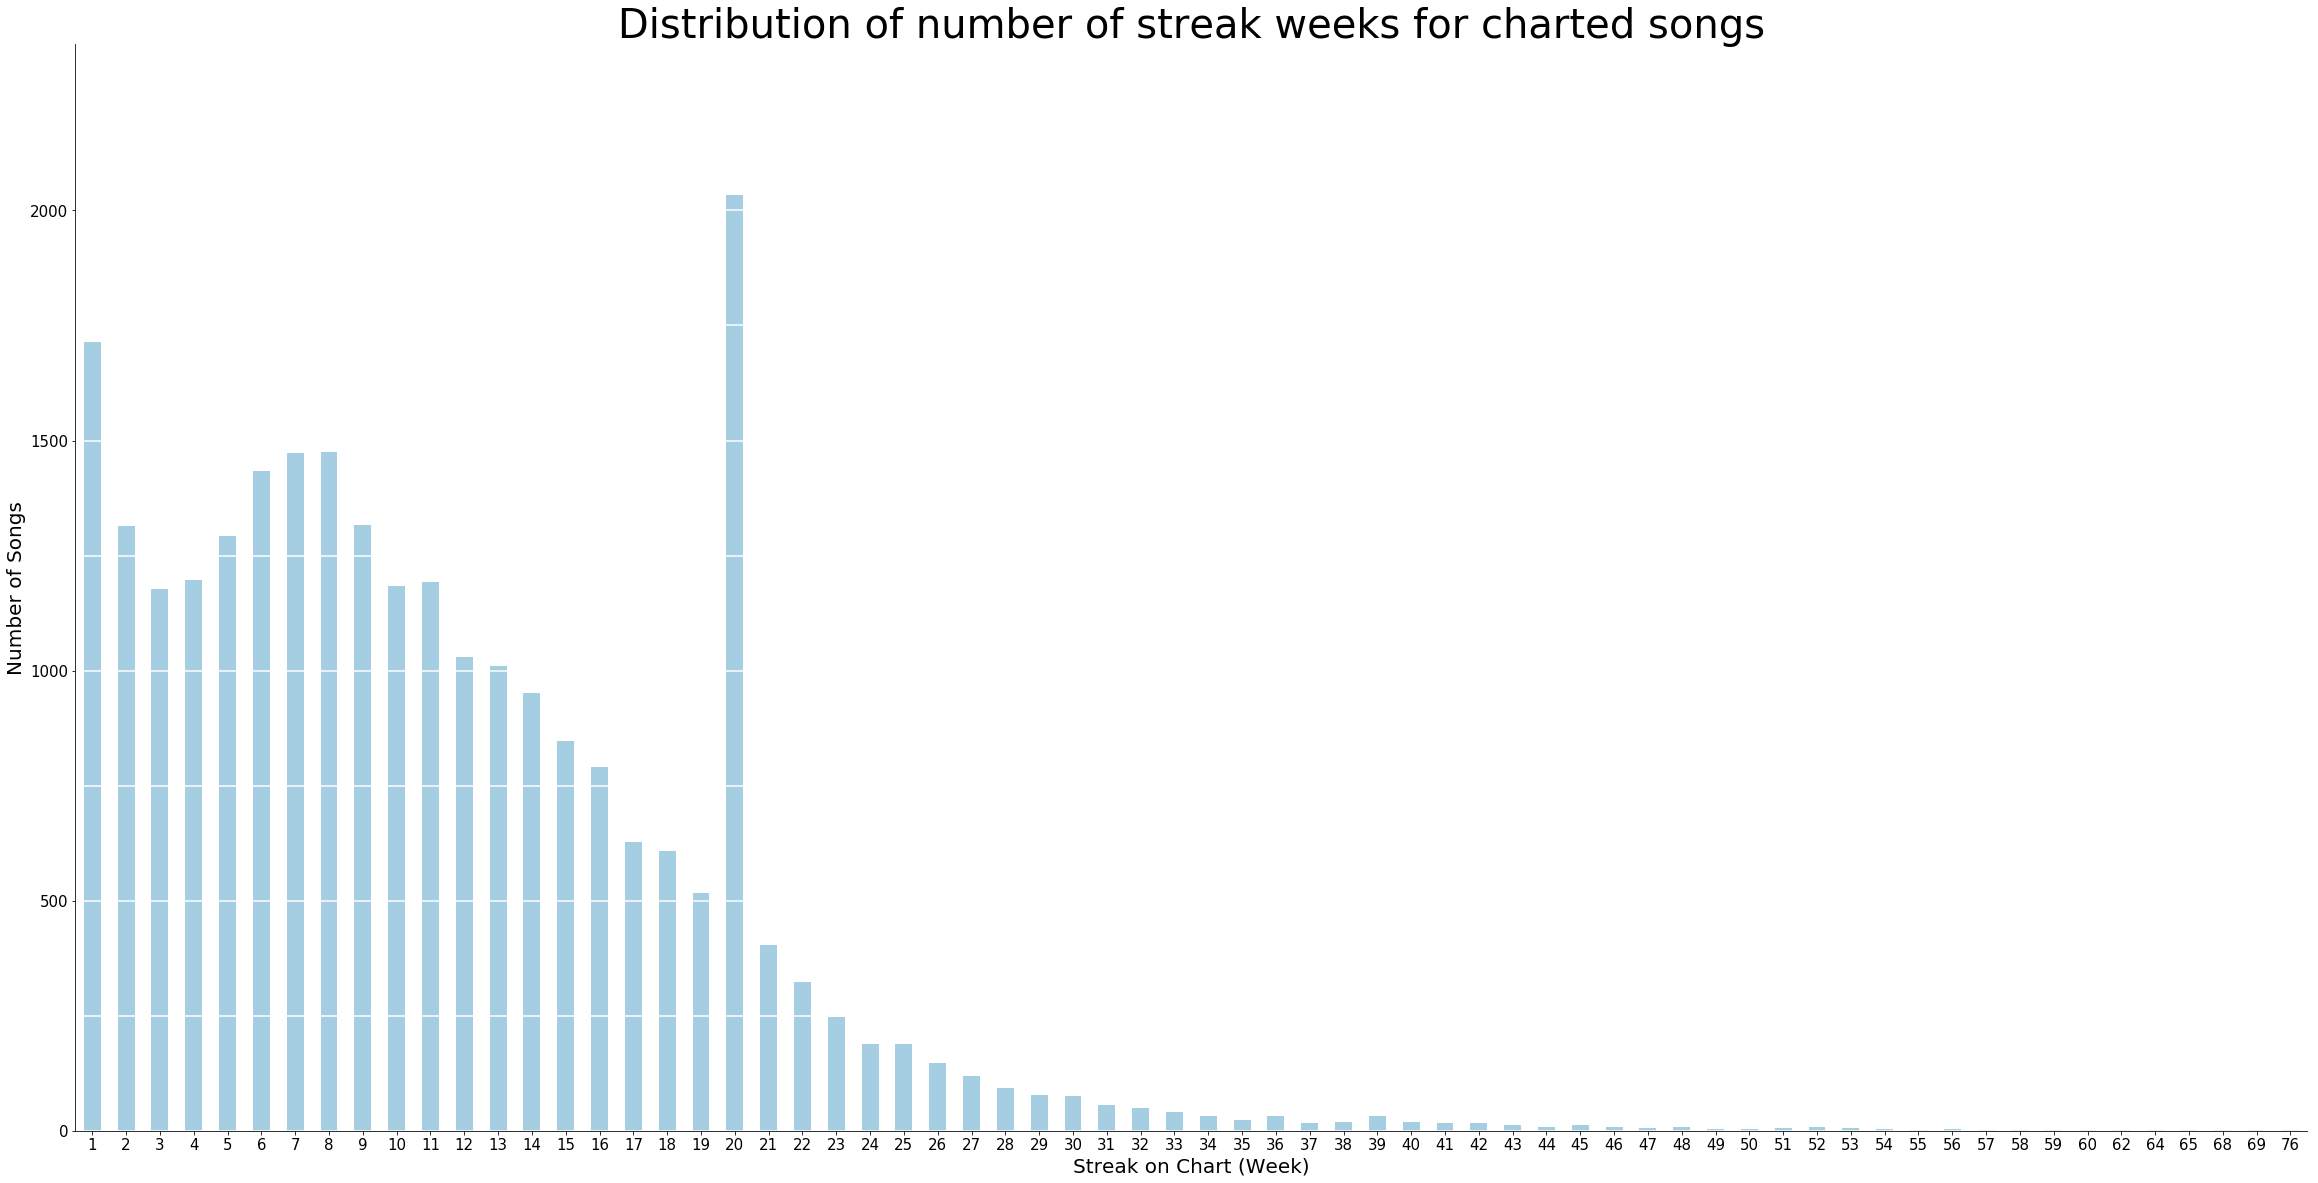

In [65]:
plt.figure(figsize=(40,20))
ranking_dist_df['weeks_on_chart'].value_counts().sort_index().plot(kind='bar', colormap='Paired')

ax = plt.gca()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.xaxis.set_ticks_position('bottom')
locs_y, labels_y = plt.yticks()

for loc in locs_y:
    ax.axhline(loc, color='white')

plt.title('Distribution of number of streak weeks for charted songs', fontsize=40)
plt.ylabel('Number of Songs', fontsize=20)
plt.xlabel('Streak on Chart (Week)', fontsize=20)
plt.xticks(rotation=0, fontsize=15)
plt.yticks(fontsize=15)

In [51]:
ranking_dist_df['weeks_on_chart'].value_counts()

20    2034
1     1714
8     1476
7     1472
6     1434
9     1316
2     1315
5     1292
4     1196
11    1193
10    1184
3     1178
12    1030
13    1009
14     951
15     847
16     791
17     628
18     608
19     516
21     403
22     323
23     248
24     189
25     188
26     147
27     119
28      94
29      78
30      76
      ... 
35      23
38      20
40      19
42      18
41      17
37      17
43      12
45      12
44       9
48       8
52       8
46       8
47       7
53       6
51       5
50       4
49       4
54       3
56       3
58       2
55       2
64       1
62       1
57       1
65       1
76       1
60       1
59       1
69       1
68       1
Name: weeks_on_chart, Length: 66, dtype: int64

In [68]:
ranking_dist_df.loc[ranking_dist_df.songid == 'Call Me MaybeCarly Rae Jepsen']['week_position'].tolist()[0]

[38,
 31,
 24,
 23,
 18,
 10,
 10,
 8,
 7,
 5,
 4,
 4,
 2,
 2,
 2,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 3,
 4,
 6,
 10,
 12,
 13,
 12,
 15,
 20,
 23,
 25,
 25,
 30,
 27,
 31,
 34,
 41,
 45,
 45,
 43,
 27,
 29,
 40,
 41,
 43,
 48]

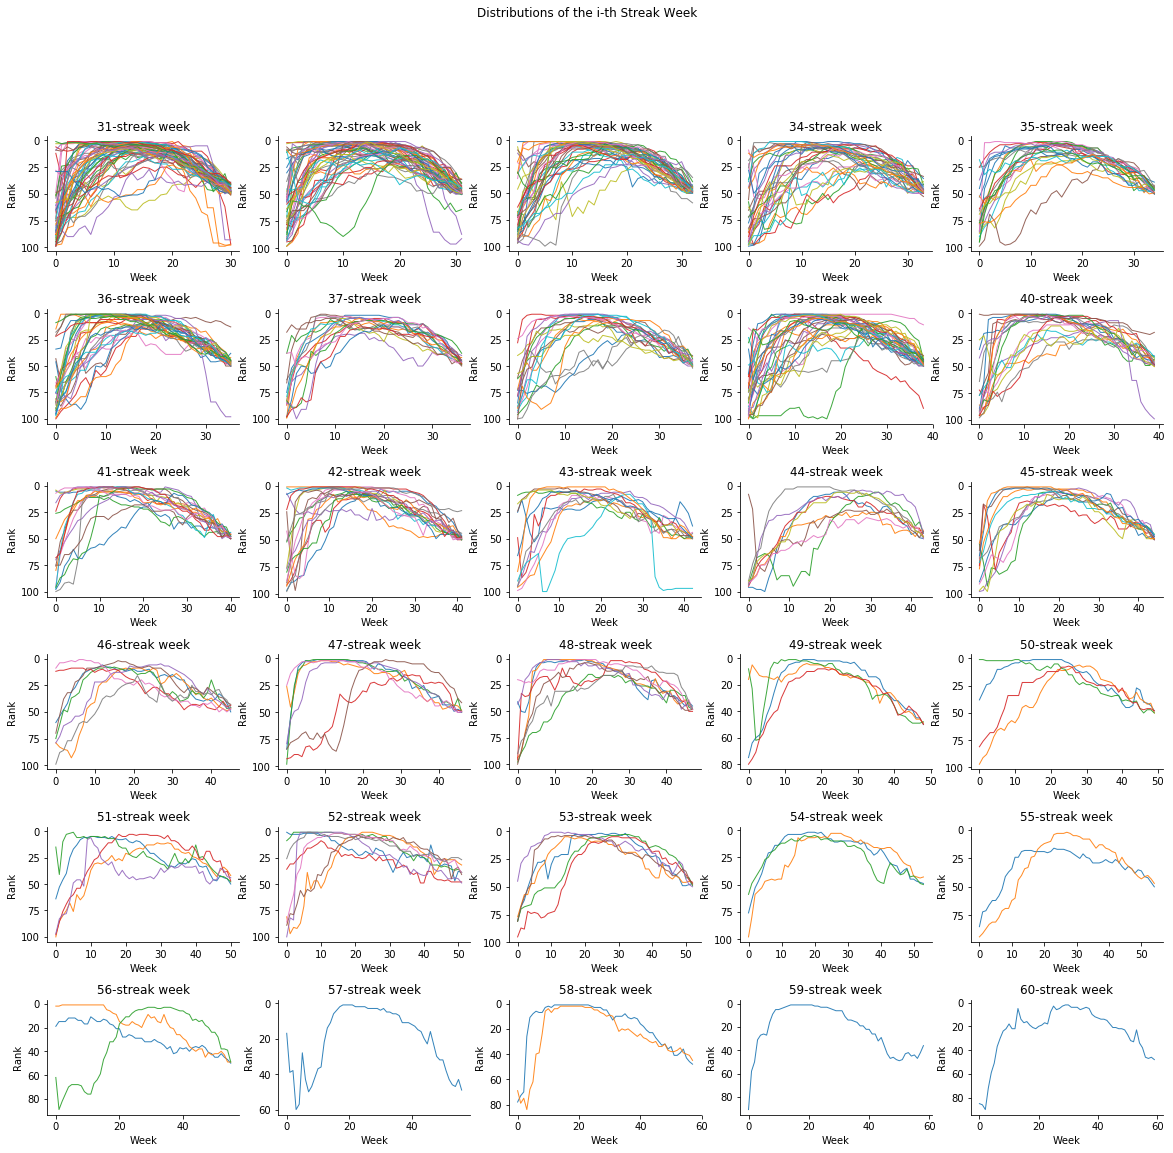

In [131]:

num=0
feature = []
count = 0
fig, axs = plt.subplots(6,5, figsize=(20, 18), facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace=0.5)
fig.suptitle('Distributions of the i-th Streak Week')
axs = axs.ravel()
for idx in range(30):
    strike_week = idx + 31
    for column in list(ranking_dist_df.loc[ranking_dist_df.weeks_on_chart == strike_week]['songid']):
        num += 1
        try:
            if len(ranking_dist_df.loc[ranking_dist_df.songid == column]['week_position'].tolist()) > 1:
                feature.append(column)
            
            axs[idx].plot([val for val in range(strike_week)], ranking_dist_df.loc[ranking_dist_df.songid == column]['week_position'].tolist()[0], \
                      marker='', linewidth=1, alpha=0.9, label=column)

        except:
            pass
    count += 1
    axs[idx].invert_yaxis()
    axs[idx].spines['right'].set_visible(False)
    axs[idx].spines['top'].set_visible(False)
    axs[idx].xaxis.set_ticks_position('bottom')
    axs[idx].set_ylabel('Rank')
    axs[idx].set_xlabel('Week')
#     axs[idx].set_xticks(rotation=0)
    axs[idx].set_title('{}-streak week'.format(strike_week))

In [117]:
feature

[]

In [109]:
train_df.loc[train_df.weeks_on_chart == 87]

,url,weekid,week_position,song,performer,songid,instance,previous_week_position,peak_position,weeks_on_chart,year,week
203955,http://www.billboard.com/charts/hot-100/2012-0...,2012-08-18,93,Radioactive,Imagine Dragons,RadioactiveImagine Dragons,1,NaN,3,87,2012,33
203956,http://www.billboard.com/charts/hot-100/2012-0...,2012-08-25,98,Radioactive,Imagine Dragons,RadioactiveImagine Dragons,1,93.0,3,87,2012,34
203957,http://www.billboard.com/charts/hot-100/2012-0...,2012-09-29,91,Radioactive,Imagine Dragons,RadioactiveImagine Dragons,2,NaN,3,87,2012,39
203958,http://www.billboard.com/charts/hot-100/2012-1...,2012-10-06,93,Radioactive,Imagine Dragons,RadioactiveImagine Dragons,2,91.0,3,87,2012,40
203959,http://www.billboard.com/charts/hot-100/2012-1...,2012-10-13,95,Radioactive,Imagine Dragons,RadioactiveImagine Dragons,2,93.0,3,87,2012,41
203960,http://www.billboard.com/charts/hot-100/2012-1...,2012-10-20,98,Radioactive,Imagine Dragons,RadioactiveImagine Dragons,2,95.0,3,87,2012,42
203961,http://www.billboard.com/charts/hot-100/2012-1...,2012-10-27,90,Radioactive,Imagine Dragons,RadioactiveImagine Dragons,2,98.0,3,87,2012,43
203962,http://www.billboard.com/charts/hot-100/2012-1...,2012-11-03,93,Radioactive,Imagine Dragons,RadioactiveImagine Dragons,2,90.0,3,87,2012,44
203963,http://www.billboard.com/charts/hot-100/2012-1...,2012-11-10,90,Radioactive,Imagine Dragons,RadioactiveImagine Dragons,2,93.0,3,87,2012,45
203964,http://www.billboard.com/charts/hot-100/2012-1...,2012-11-17,87,Radioactive,Imagine Dragons,RadioactiveImagine Dragons,2,90.0,3,87,2012,46


In [ ]:

 
# multiple line plot
# for strike_week in range(min(ranking_dist_df['Weeks on Chart']), max(ranking_dist_df['Weeks on Chart']) + 1):
palette = plt.get_cmap('Accent')
num=0

feature = []
# for strike_week in range(, max(ranking_dist_df['Weeks on Chart']) + 1):
for strike_week in range(50, 51):
    for column in list(ranking_dist_df.loc[ranking_dist_df.weeks_on_chart == strike_week,['song', 'performer']]):
        num += 1
        print(column)
#         try:
#             if len(ranking_dist_df.loc[ranking_dist_df['Song'] == column]['rank'].tolist()) > 1:
#                 feature.append(column)
#             plt.plot([val for val in range(strike_week)], ranking_dist_df.loc[(ranking_dist_df['Song'] == column) & ]['rank'].tolist()[0], \
#                      color=palette(num), marker='', linewidth=1, alpha=0.9, label=column)
#         except:
#             pass


In [ ]:
type(ranking_dist_df.loc[ranking_dist_df['Weeks on Chart'] == 1]['Performer'])

In [ ]:
ranking_dist_df.loc[ranking_dist_df.Song == 'Someday']

In [ ]:
train_df.loc[train_df.Song == 'Shake It Off']

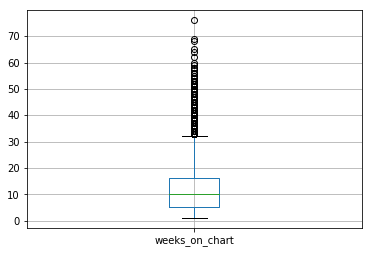

In [132]:
ranking_dist_df.boxplot()

In [ ]:
ranking_dist_df.describe()

In [ ]:
x_data = np.linspace(0, 88, num=50)
y_data = ranking_dist_df.loc[ranking_dist_df['Weeks on Chart'] == strike_week]['Song']

# # And plot it
# import matplotlib.pyplot as plt
# plt.figure(figsize=(6, 4))
# plt.scatter(x_data, y_data)

In [ ]:
print(len(weird))

In [ ]:
for idx, data in enumerate(weird):
    if idx < 10: 
        print(data)
        print(train_df.loc[(train_df.Song == data[0]) & (train_df.Performer == data[1])]['week'])

In [ ]:
train_df.loc[(train_df.Song == "(It's Just) The Way That You Love Me") & (train_df.Performer == 'Paula Abdul')]

In [ ]:
len(train_df.loc[(train_df.Song == "(It's Just) The Way That You Love Me") & (train_df.Performer == 'Paula Abdul')])